In [1]:
import warnings
warnings.filterwarnings("ignore")

import os

import time

import numpy as np
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn import set_config
set_config(transform_output = "pandas")
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, FunctionTransformer
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
from sklearn.datasets import load_diabetes
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# calcula las distancias entre puntos
from scipy.spatial.distance import cdist

from dateutil.relativedelta import relativedelta

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)  # Muestra todas las columnas


# 1. Importación de los datos

In [2]:
# Cargamos el DataFrame desde un archivo pickle
df = pd.read_pickle("data/df_easy_clean.pkl")

In [3]:
# Ordenamos el DataFrame 'df' por las columnas 'pk_cid' y 'pk_partition'
# Esto asegura que los datos de cada cliente ('pk_cid') estén agrupados y ordenados cronológicamente por 'pk_partition'
df = df.sort_values(by=["pk_cid", "pk_partition"])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5954247 entries, 1479563 to 5679912
Data columns (total 39 columns):
 #   Column                             Dtype         
---  ------                             -----         
 0   entry_channel                      object        
 1   payroll                            int16         
 2   pension_plan                       int16         
 3   gender                             object        
 4   pk_cid                             int32         
 5   pk_partition                       datetime64[ns]
 6   entry_date                         datetime64[ns]
 7   active_customer                    int16         
 8   segment                            object        
 9   short_term_deposit                 int16         
 10  loans                              int16         
 11  mortgage                           int16         
 12  funds                              int16         
 13  securities                         int16         
 14  l

# 2. EDA y creación de las variables

## 2.1. DEMOGRAFICAS

In [5]:
# GENDER

# Convertimos la columna 'gender' a valores numéricos: 1 para 'H' (hombre) y 0 para cualquier otro valor.
# Utilizamos np.where para realizar esta conversión de manera eficiente.
df["gender"] = np.where(df["gender"] == "H", 1, 0)

<Axes: xlabel='salary'>

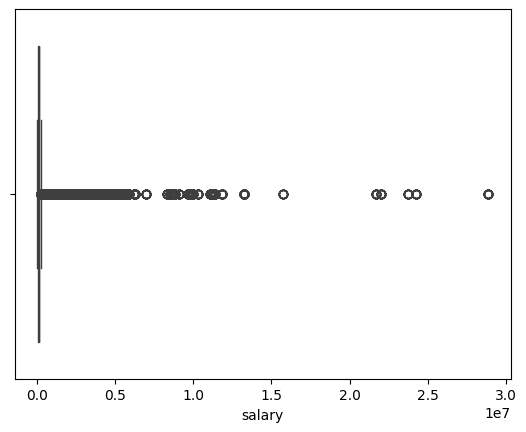

In [6]:
# SALARIO

# Utilizamos Seaborn para crear un boxplot de la columna 'salary' del DataFrame 'df'.

sns.boxplot(x=df['salary'])


In [7]:
# Obtener la fecha mínima en la columna 'pk_partition'
# Esto nos da la fecha más antigua registrada en la columna 'pk_partition'
df['pk_partition'].min()

Timestamp('2018-01-28 00:00:00')

In [8]:
# Filtramos el DataFrame 'df' para obtener solo las filas donde el salario ('salary') es mayor a 10,000,000
# Luego, seleccionamos las columnas 'segment', 'salary' y 'age' de esas filas
filtered_df = df[df['salary'] > 10000000][['segment', 'salary', 'age']]

# Ordenamos el DataFrame filtrado por la columna 'salary' en orden descendente
sorted_df = filtered_df.sort_values(by="salary", ascending=False)

# Contamos las ocurrencias únicas de cada combinación de valores en las columnas seleccionadas
result = sorted_df.value_counts()

# Mostramos el resultado
result

segment             salary       age
03 - UNIVERSITARIO  11341152.48  22     33
                    13268621.28  24     18
                    11139895.56  27     17
                    24253236.93  30     17
01 - TOP            10270345.11  51     16
03 - UNIVERSITARIO  13268621.28  23     16
                    11341152.48  21     13
                    13268621.28  29     12
                    11857856.46  24     12
                    23720066.55  25     11
                    11804014.98  30     11
02 - PARTICULARES   22034738.76  21     11
                    21724186.50  28     10
03 - UNIVERSITARIO  28894395.51  25      9
02 - PARTICULARES   28894395.51  45      9
                    13268621.28  49      9
                    11139895.56  39      8
                    13268621.28  50      8
03 - UNIVERSITARIO  11032081.77  25      7
02 - PARTICULARES   11267056.83  21      7
                    15711716.46  49      6
03 - UNIVERSITARIO  11804014.98  31      6
02 - PARTICULARES

In [9]:
# Filtramos el DataFrame 'df' para obtener solo las filas donde el segmento es '03 - UNIVERSITARIO' y el salario es mayor a 10,000,000
filtered_df = df[(df['segment'] == '03 - UNIVERSITARIO') & (df['salary'] > 10000000)]

# Contamos las ocurrencias únicas de cada valor en la columna 'salary' del DataFrame filtrado
salary_counts = filtered_df['salary'].value_counts()

# Mostramos el resultado
salary_counts

salary
13268621.28    51
11341152.48    51
24253236.93    17
11804014.98    17
11139895.56    17
11857856.46    17
28894395.51    13
11032081.77    11
23720066.55    11
Name: count, dtype: int64

In [10]:
# Agrupamos el DataFrame 'df' por la columna 'segment'
# Luego, calculamos la media de la columna 'salary' para cada grupo de 'segment'
# Esto nos da el salario promedio para cada segmento
df.groupby('segment')['salary'].mean()

segment
01 - TOP              147813.906899
02 - PARTICULARES     114716.346779
03 - UNIVERSITARIO    114368.629120
Desconocido           113750.114205
Name: salary, dtype: float64

In [11]:
# Filtramos el DataFrame 'df' para obtener solo las filas donde el salario ('salary') es mayor a 15,000,000
# Luego, seleccionamos la columna 'pk_cid' de esas filas y contamos los valores únicos
# Esto nos da el número de clientes únicos que tienen un salario mayor a 15,000,000
df[df['salary'] > 15000000]['pk_cid'].nunique()

8

In [12]:
# SEGMENT

# Convertimos la columna 'segment' en variables dummy (variables indicadoras).
# Esto crea una nueva columna para cada valor único en 'segment' con valores 0 o 1.
# dtype='int8' asegura que las nuevas columnas sean del tipo entero de 8 bits para ahorrar memoria.
df = pd.get_dummies(df, columns=['segment'], dtype='int8')

## 2.2. COMPORTAMIENTO FINANCIERO

In [13]:
# PRODUCTOS TOTALES POR CLIENTE

# Definimos las listas de productos por tipo: cuentas, ahorro/inversión y financiación
prod_cuentas = ['em_account_p', 'em_account_pp', 'em_acount', 'emc_account', 'debit_card', 'payroll', 'payroll_account']
prod_ahorro_inversion = ['securities', 'pension_plan', 'short_term_deposit', 'long_term_deposit', 'funds']
prod_financiacion = ['mortgage', 'loans', 'credit_card']

# Combinamos todas las listas de productos en una sola lista
productos_total = prod_cuentas + prod_ahorro_inversion + prod_financiacion

# Calculamos el total de productos por cliente sumando los valores de las columnas de productos
# Convertimos el resultado a tipo entero de 16 bits para ahorrar memoria
df["total_productos"] = df[productos_total].sum(axis=1).astype('int16')


In [ ]:
def calcular_productos_unicos_totales(df, cliente_col, productos_cols):
    """
    Calcula el total de productos únicos contratados por cada cliente, incluyendo todos los productos.
    Argumentos:
        df (pd.DataFrame): DataFrame con datos históricos de clientes.
        cliente_col (str): Nombre de la columna que identifica a los clientes.
        productos_cols (list): Lista de columnas que representan todos los productos contratados.
    Devuelve:
        pd.DataFrame: DataFrame con una columna adicional con el total de productos únicos.
    """
    # Agrupamos el DataFrame por cliente y calculamos el máximo para cada producto
    # Esto nos permite saber si el cliente ha tenido al menos una vez cada producto
    productos_historicos = df.groupby(cliente_col)[productos_cols].max()
    
    # Sumamos los productos únicos contratados por cliente
    productos_historicos["total_productos_unicos"] = productos_historicos.sum(axis=1)
    
    # Mapeamos esta información de vuelta al DataFrame original
    df["total_productos_unicos"] = df[cliente_col].map(productos_historicos["total_productos_unicos"])
    
    # Retornamos el DataFrame actualizado
    return df

In [15]:
# Calculamos el total de productos únicos contratados por cada cliente utilizando la función definida previamente

# Agrupamos el DataFrame por cliente y calculamos el máximo para cada producto
# Esto nos permite saber si el cliente ha tenido al menos una vez cada producto
productos_historicos = df.groupby("pk_cid")[productos_total].max()

# Sumamos los productos únicos contratados por cliente
productos_historicos["total_productos_unicos"] = productos_historicos.sum(axis=1)

# Mapeamos esta información de vuelta al DataFrame original
df["total_productos_unicos"] = df["pk_cid"].map(productos_historicos["total_productos_unicos"])

# Retornamos el DataFrame actualizado utilizando la función definida previamente
df = calcular_productos_unicos_totales(df, "pk_cid", productos_total)


In [16]:
# CANTIDAD PRODUCTOS POR CLIENTE

# Calculamos el total de productos de cuenta por cliente sumando los valores de las columnas correspondientes
# Convertimos el resultado a tipo entero de 16 bits para ahorrar memoria
df["total_productos_cuenta"] = df[prod_cuentas].sum(axis=1).astype('int16')

# Calculamos el total de productos de ahorro e inversión por cliente sumando los valores de las columnas correspondientes
# Convertimos el resultado a tipo entero de 16 bits para ahorrar memoria
df["total_productos_ahorro_inversion"] = df[prod_ahorro_inversion].sum(axis=1).astype('int16')

# Calculamos el total de productos de financiación por cliente sumando los valores de las columnas correspondientes
# Convertimos el resultado a tipo entero de 16 bits para ahorrar memoria
df["total_productos_financiacion"] = df[prod_financiacion].sum(axis=1).astype('int16')



In [17]:
# VARIEDAD DE PRODUCTOS

# Agrupamos el DataFrame 'df' por la columna 'pk_cid' y sumamos las columnas de productos
# Esto nos da el total de cada tipo de producto por cliente
variedad_productos = df.groupby("pk_cid")[["total_productos_cuenta", "total_productos_ahorro_inversion", "total_productos_financiacion"]].sum()

# Convertimos los totales a valores booleanos (True si el total es mayor a 0, False en caso contrario)
# Luego, sumamos estos valores booleanos a lo largo del eje de las columnas
# Esto nos da la cantidad de tipos de productos que ha tenido cada cliente
variedad_productos = variedad_productos.gt(0).sum(axis=1).reset_index()

# Renombramos la columna resultante a 'variedad_productos' para mayor claridad
variedad_productos.rename(columns={0: "variedad_productos"}, inplace=True)

# Unimos el DataFrame 'variedad_productos' al DataFrame original 'df' utilizando la columna 'pk_cid'
# Esto agrega la nueva columna 'variedad_productos' al DataFrame original
df = df.merge(variedad_productos, on="pk_cid", how="left")

## 2.3. FIDELIZACIÓN Y ACTIVIDAD

In [18]:
# ANTIGUEDAD

# Calculamos la antigüedad de cada cliente en días restando la fecha de entrada ('entry_date') de la fecha más reciente en la columna 'pk_partition'
df['days_since_entry'] = df['pk_partition'].max() - df['entry_date']

# Convertimos la diferencia de tiempo a días y actualizamos la columna 'days_since_entry'
df['days_since_entry'] = df['days_since_entry'].dt.days

In [19]:
# NUMERO TOTAL DE COMPRAS - ULTIMOS 6 MESES

# Iteramos sobre cada producto en la lista 'productos_total'
for prod in productos_total:
    # Creamos una nueva columna para cada producto que indica si ha habido una nueva contratación
    # Comparamos el valor actual del producto con el valor anterior (desplazado por 1) para cada cliente
    # Si el valor actual es mayor que el anterior, significa que hay una nueva contratación (1), de lo contrario (0)
    df[f"{prod}_nuevo"] = (df[prod] > df.groupby("pk_cid")[prod].shift(1)).astype(int)

# Contamos el número de nuevos productos contratados en los últimos 6 meses para cada cliente
# Agrupamos por 'pk_cid' y aplicamos una ventana de 6 meses para contar las nuevas contrataciones
df["productos_contratados_ultimos_6m"] = df.groupby("pk_cid")[
    [f"{p}_nuevo" for p in productos_total]
].rolling(window=6, min_periods=1).sum().reset_index(level=0, drop=True).sum(axis=1)


In [20]:
# FIDELIZACIÓN

def fidelizacion(df):
    def count_consecutive(series):
        # Inicializamos un contador y una lista para almacenar los resultados
        counter = 0
        result = []
        # Iteramos sobre cada valor en la serie
        for x in series:
            # Si el valor es mayor a 0, incrementamos el contador
            if x > 0:
                counter += 1
            else:
                # Si el valor es 0 o menor, reiniciamos el contador
                counter = 0
            # Agregamos el valor del contador a la lista de resultados
            result.append(counter)
        # Retornamos la lista de resultados
        return result
    
    # Aplicamos la función count_consecutive a cada grupo de 'pk_cid' en la columna 'total_productos'
    # Esto nos da la fidelización de cada cliente en términos de productos consecutivos
    df["fidelizacion"] = df.groupby("pk_cid")["total_productos"].transform(count_consecutive)
    
    # Retornamos el DataFrame actualizado
    return df

In [21]:
fidelizacion(df)

,entry_channel,payroll,pension_plan,gender,pk_cid,pk_partition,entry_date,active_customer,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll_account,emc_account,debit_card,em_account_p,em_acount,country_id,region_code,age,deceased,salary,tiene_prod_cuenta,tiene_prod_ahorro_inv,tiene_prod_financiacion,days_since_entry,variacion_salarial_abs,total_sin_tiene_prod_cuenta,total_sin_tiene_prod_ahorro_inv,total_sin_tiene_prod_financiacion,ha_recomprado_prod_cuenta,ha_recomprado_prod_ahorro,ha_recomprado_prod_finan,salary_increase_pct,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,total_productos,total_productos_unicos,total_productos_cuenta,total_productos_ahorro_inversion,total_productos_financiacion,variedad_productos,em_account_p_nuevo,em_account_pp_nuevo,em_acount_nuevo,emc_account_nuevo,debit_card_nuevo,payroll_nuevo,payroll_account_nuevo,securities_nuevo,pension_plan_nuevo,short_term_deposit_nuevo,long_term_deposit_nuevo,funds_nuevo,mortgage_nuevo,loans_nuevo,credit_card_nuevo,productos_contratados_ultimos_6m,fidelizacion
0,KAT,0,0,1,15891,2018-07-28,2018-07-28,1,0,0,0,0,0,0,0,0,0,0,0,0,1,ES,28.0,59,N,170656.930000,0,0,0,304,0.000000,0,1,1,0,0,0,0.000000,0,0,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1
1,KAT,0,0,1,15891,2018-08-28,2018-07-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,28.0,59,N,176309.679845,0,0,0,304,5652.749845,0,1,1,0,0,0,3.312347,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0
2,KAT,0,0,1,16063,2018-11-28,2018-11-19,1,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,28.0,62,N,141213.851739,0,0,0,190,0.000000,0,0,0,0,0,0,0.000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0
3,KAT,0,0,1,16063,2018-12-28,2018-11-19,1,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,28.0,62,N,160980.198311,0,0,0,190,19766.346572,0,0,0,0,0,0,13.997456,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0
4,KAT,0,0,1,16063,2019-01-28,2018-11-19,1,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,28.0,62,N,160980.198311,0,0,0,190,19766.346572,0,0,0,0,0,0,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5954242,KHE,0,0,0,1553685,2019-05-28,2019-05-31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,13.0,52,N,52673.925000,0,0,0,-3,0.000000,0,0,0,0,0,0,0.000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0
5954243,KHE,0,0,1,1553686,2019-05-28,2019-05-31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,41.0,30,N,113105.705172,0,0,0,-3,0.000000,0,0,0,0,0,0,0.000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0
5954244,KHE,0,0,0,1553687,2019-05-28,2019-05-31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,28.0,21,N,170286.024236,0,0,0,-3,0.000000,0,0,0,0,0,0,0.000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0
5954245,KHE,0,0,1,1553688,2019-05-28,2019-05-31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,39.0,43,N,355549.267500,0,0,0,-3,0.000000,0,0,0,0,0,0,0.000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0


In [22]:
# ULTIMA COMPRA DESDE EL ULTIMO MES

# Definimos una lista de columnas que representan diferentes productos financieros
columnas = ['em_account_p', 'em_account_pp', 'em_acount', 'emc_account', 'debit_card', 'payroll', 'payroll_account', 
            'securities', 'pension_plan', 'short_term_deposit', 'long_term_deposit', 'funds', 'mortgage', 'loans', 'credit_card']

# Creamos una nueva columna 'purchase_made' que indica si se ha realizado una nueva compra de cualquier producto
# Utilizamos la función diff() para calcular la diferencia entre el valor actual y el valor anterior de cada producto
# Luego, utilizamos gt(0) para verificar si la diferencia es mayor a 0 (indicando una nueva compra)
# Finalmente, utilizamos any(axis=1) para verificar si alguna de las columnas de productos tiene una nueva compra
df['purchase_made'] = df[columnas].diff().gt(0).any(axis=1)

# Filtramos el DataFrame 'df' para obtener solo las filas donde se ha realizado una nueva compra ('purchase_made' == True)
# Agrupamos por 'pk_cid' y seleccionamos la última fecha de compra ('pk_partition') para cada cliente
# Convertimos el resultado en un DataFrame y reiniciamos el índice
df_lastpurchase = df[df['purchase_made'] == True].groupby(['pk_cid'])['pk_partition'].last().to_frame().reset_index()


In [23]:
# Calculamos la diferencia entre la fecha más reciente de compra y la fecha de la última compra para cada cliente
# Esto nos da el tiempo transcurrido desde la última compra en días

# 1. Obtenemos la fecha más reciente de compra en la columna 'pk_partition'
fecha_maxima_compra = df_lastpurchase['pk_partition'].max()

# 2. Restamos la fecha de la última compra de cada cliente ('pk_partition') de la fecha más reciente de compra
# Esto nos da el tiempo transcurrido desde la última compra en días para cada cliente
df_lastpurchase['last_purchase'] = fecha_maxima_compra - df_lastpurchase['pk_partition']

In [24]:
del (df_lastpurchase["pk_partition"])

In [25]:
# Unimos el DataFrame 'df' con el DataFrame 'df_lastpurchase' utilizando la columna 'pk_cid' como clave
# La unión se realiza a la izquierda, lo que significa que mantenemos todas las filas de 'df' y agregamos las columnas de 'df_lastpurchase'
df = pd.merge(df, df_lastpurchase, on='pk_cid', how='left')

# Rellenamos los valores nulos en la columna 'last_purchase' con la diferencia entre la fecha más reciente y la fecha más antigua en 'pk_partition'
# Esto asegura que los clientes sin una última compra registrada tengan un valor por defecto
df['last_purchase'] = df['last_purchase'].fillna(df['pk_partition'].max() - df['pk_partition'].min())

In [26]:
# Convertimos la columna 'pk_partition' a formato datetime y ordenamos el DataFrame por 'pk_cid' y 'pk_partition'
df['pk_partition'] = pd.to_datetime(df['pk_partition'])
df = df.sort_values(['pk_cid', 'pk_partition'])

# Calculamos la diferencia en 'total_productos' para detectar si hubo una compra en ese registro
# Obtenemos el primer valor de 'total_productos' para cada cliente
first_val = df.groupby('pk_cid')['total_productos'].transform('first')
# Creamos una columna 'compra_evento' que indica si hubo una compra (True) o no (False)
df['compra_evento'] = df.groupby('pk_cid')['total_productos'].diff().fillna(first_val) > 0

# Creamos una columna 'fecha_compra' que contiene la fecha de compra en el momento del evento de compra
df['fecha_compra'] = df['pk_partition'].where(df['compra_evento'])

# Rellenamos hacia adelante las fechas de compra para cada cliente
df['fecha_compra'] = df.groupby('pk_cid')['fecha_compra'].ffill()

# Calculamos los meses transcurridos desde la última compra
df['meses_desde_ultima_compra'] = ((df['pk_partition'] - df['fecha_compra']).dt.days)/30

# Rellenamos los valores nulos en 'meses_desde_ultima_compra' con la suma del máximo y la media de la columna
df['meses_desde_ultima_compra'] = df['meses_desde_ultima_compra'].fillna(df['meses_desde_ultima_compra'].max()+df['meses_desde_ultima_compra'].mean())

In [27]:
## ratio dias compra

# Calculamos la diferencia en meses desde la última compra para cada fila del DataFrame 'df'
# Utilizamos el método diff() para obtener la diferencia entre el valor actual y el valor anterior en la columna 'meses_desde_ultima_compra'
# Luego, utilizamos clip(lower=0) para asegurarnos de que no haya valores negativos en la diferencia
# Finalmente, rellenamos los valores nulos resultantes con 0 utilizando fillna(0)
df['meses_desde_ultima_compra_diff'] = df['meses_desde_ultima_compra'].diff().clip(lower= 0).fillna(0)


In [28]:
# Agrupamos el DataFrame 'df' por la columna 'pk_cid' y sumamos los valores de la columna 'meses_desde_ultima_compra_diff'
# Convertimos el resultado en un diccionario donde las claves son 'pk_cid' y los valores son la suma de 'meses_desde_ultima_compra_diff'
diccionario_suma_dias = df.groupby('pk_cid')['meses_desde_ultima_compra_diff'].sum().to_dict()

# Agrupamos el DataFrame 'df' por la columna 'pk_cid' y sumamos los valores de la columna 'purchase_made'
# Convertimos el resultado en un diccionario donde las claves son 'pk_cid' y los valores son la suma de 'purchase_made'
diccionario_suma_compras = df.groupby('pk_cid')['purchase_made'].sum().to_dict()


In [29]:
# Calculamos el ratio de meses entre compras para cada cliente
# Utilizamos el método map() para aplicar una función lambda a cada valor de 'pk_cid'
df["ratio_meses_compras"] = df["pk_cid"].map(
    # La función lambda toma el 'pk_cid' y busca su valor en 'diccionario_suma_dias' y 'diccionario_suma_compras'
    lambda x: diccionario_suma_dias.get(x, 0) / diccionario_suma_compras.get(x, 1) 
    # Si el valor en 'diccionario_suma_compras' es diferente de 0, realizamos la división
    if diccionario_suma_compras.get(x, 1) != 0 else None
    # Si el valor en 'diccionario_suma_compras' es 0, retornamos None
).fillna(0)  # Rellenamos los valores nulos con 0


In [30]:
df = df.copy()

# Convertimos la columna 'days_since_entry' a meses dividiendo los días entre 30.4.
# Utilizamos clip(lower=0) para asegurarnos de que no haya valores negativos y fillna(0) para rellenar valores nulos.
df['months_since_entry'] = ((df['pk_partition'] - df['entry_date']).dt.days / 30.4).clip(lower=0).fillna(0)

# Calculamos la diferencia en 'total_productos' para detectar si hubo una compra en ese registro.
# Utilizamos clip(lower=0) para asegurarnos de que no haya valores negativos y fillna(0) para rellenar valores nulos.
df['total_prod_comprados'] = df['total_productos'].diff().clip(lower=0).fillna(0)

# Calculamos el total acumulado de productos comprados por cliente utilizando cumsum() después de agrupar por 'pk_cid'.
df['total_prod_comprados_cum'] = df.groupby('pk_cid')['total_prod_comprados'].cumsum()

# Calculamos la frecuencia promedio de compras por mes dividiendo el total acumulado de productos comprados por los meses desde la entrada.
df['ratio_compras'] = df['total_prod_comprados_cum'] / df['months_since_entry']

# Rellenamos los valores nulos en 'ratio_compras' con 0.
df['ratio_compras'] = df['ratio_compras'].fillna(0)

# Reemplazamos los valores infinitos y negativos infinitos en 'ratio_compras' con 0.
df['ratio_compras'] = df['ratio_compras'].replace([np.inf, -np.inf], 0)

# Filtramos el DataFrame para mostrar solo las filas donde 'pk_cid' es igual a 1378571.
df[df['pk_cid']==1378571]

,entry_channel,payroll,pension_plan,gender,pk_cid,pk_partition,entry_date,active_customer,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll_account,emc_account,debit_card,em_account_p,em_acount,country_id,region_code,age,deceased,salary,tiene_prod_cuenta,tiene_prod_ahorro_inv,tiene_prod_financiacion,days_since_entry,variacion_salarial_abs,total_sin_tiene_prod_cuenta,total_sin_tiene_prod_ahorro_inv,total_sin_tiene_prod_financiacion,ha_recomprado_prod_cuenta,ha_recomprado_prod_ahorro,ha_recomprado_prod_finan,salary_increase_pct,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,total_productos,total_productos_unicos,total_productos_cuenta,total_productos_ahorro_inversion,total_productos_financiacion,variedad_productos,em_account_p_nuevo,em_account_pp_nuevo,em_acount_nuevo,emc_account_nuevo,debit_card_nuevo,payroll_nuevo,payroll_account_nuevo,securities_nuevo,pension_plan_nuevo,short_term_deposit_nuevo,long_term_deposit_nuevo,funds_nuevo,mortgage_nuevo,loans_nuevo,credit_card_nuevo,productos_contratados_ultimos_6m,fidelizacion,purchase_made,last_purchase,compra_evento,fecha_compra,meses_desde_ultima_compra,meses_desde_ultima_compra_diff,ratio_meses_compras,months_since_entry,total_prod_comprados,total_prod_comprados_cum,ratio_compras
4777343,KHL,0,0,0,1378571,2018-01-28,2018-01-27,1,0,0,0,0,0,0,0,0,0,0,0,0,1,ES,2.0,29,N,60440.76,0,0,0,486,0.0,3,4,7,0,0,0,0.0,0,1,0,0,1,7,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1,False,273 days,True,2018-01-28,0.000000,0.000000,4.388889,0.032895,0.0,0.0,0.000000
4777344,KHL,0,0,0,1378571,2018-02-28,2018-01-27,1,0,0,0,0,0,0,0,0,0,0,0,0,1,ES,2.0,29,N,60440.76,0,0,0,486,0.0,3,4,7,0,0,0,0.0,0,1,0,0,1,7,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,2,False,273 days,False,2018-01-28,1.033333,1.033333,4.388889,1.052632,0.0,0.0,0.000000
4777345,KHL,1,1,0,1378571,2018-03-28,2018-01-27,1,0,0,0,0,0,0,0,0,1,0,1,0,0,ES,2.0,29,N,60440.76,1,1,0,486,0.0,3,4,7,0,0,0,0.0,0,1,0,0,4,7,3,1,0,2,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,4.0,3,True,273 days,True,2018-03-28,0.000000,0.000000,4.388889,1.973684,3.0,3.0,1.520000
4777346,KHL,1,1,0,1378571,2018-04-28,2018-01-27,1,1,0,0,0,0,0,0,0,1,0,1,0,0,ES,2.0,29,N,60440.76,1,1,0,486,0.0,3,4,7,0,0,0,0.0,0,1,0,0,5,7,3,2,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,5.0,4,True,273 days,True,2018-04-28,0.000000,0.000000,4.388889,2.993421,1.0,4.0,1.336264
4777347,KHL,1,1,0,1378571,2018-05-28,2018-01-27,1,1,0,0,0,0,0,0,0,1,0,1,0,0,ES,2.0,29,N,60440.76,1,1,0,486,0.0,3,4,7,0,0,0,0.0,0,1,0,0,5,7,3,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,5,False,273 days,False,2018-04-28,1.000000,1.000000,4.388889,3.980263,0.0,4.0,1.004959
4777348,KHL,1,1,0,1378571,2018-06-28,2018-01-27,1,1,0,0,0,0,0,0,0,1,0,1,0,0,ES,2.0,29,N,60440.76,1,1,0,486,0.0,3,4,7,0,0,0,0.0,0,1,0,0,5,7,3,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,6,False,273 days,False,2018-04-28,2.033333,1.033333,4.388889,5.000000,0.0,4.0,0.800000
4777349,KHL,1,1,0,1378571,2018-07-28,2018-01-27,1,0,0,0,0,0,0,0,0,1,0,1,0,0,ES,2.0,29,N,60440.76,1,1,0,486,0.0,3,4,7,0,0,0,0.0,0,1,0,0,4,7,3,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,7,False,273 days,False,2018-04-28,3.033333,1.000000,4.388889,5.986842,0.0,4.0,0.668132
4777350,KHL,1,1,0,1378571,2018-08-28,2018-01-27,1,0,0,0,0,0,1,0,0,1,0,1,0,0,ES,2.0,29,N,60440.76,1,1,0,486,0.0,3,4,7,0,0,0,0.0,0,1,0,0,5,7,3,2,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,6.0,8,True,273 days,True,2018-08-28,0.000000,0.000000,4.388889,7.006579,1.0,5.0,0.713615
4777351,KHL,1,1,0,1378571,2018-09-28,2018-01-27,1,0,0,0,0,0,1,0,0,1,0,1,0,0,ES,2.0,29,N,60440.76,1,1,0,486,0.0,3,4,7,0,0,0,0.0,0,1,0,0,5,7,3,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,9,False,273 days,False,2018-08-28,1.033333,1.033333,4.388889,8.026316,0.0,5.0,0.622951
4777352,KHL,1,1,0,1378571,2018-10-28,2018-01-27,1,0,0,0,0,0,1,0,0,1,0,1,0,0,ES,2.0,29,N,60440.76,1,1,0,486,0.0,3,4,7,0,0,0,0.0,0,1,0,0,5,7,3,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,10,False,273 days,False,2018-08-28,2.033333,1.000000,4.388889,9.013158,

In [31]:
# Contamos la cantidad de clientes ('pk_cid') que tienen una suma de compras igual a 0 en el diccionario 'diccionario_suma_compras'
# Utilizamos una comprensión de listas para iterar sobre los elementos del diccionario
# Para cada par clave-valor (key, value), verificamos si el valor es igual a 0
# Si el valor es igual a 0, incrementamos el contador
cantidad_cids_cero = sum(1 for key, value in diccionario_suma_compras.items() if value == 0)

# Imprimimos el resultado, que es la cantidad de clientes con suma de compras igual a 0
print(f"Número de pk_cid con suma 0: {cantidad_cids_cero}")

Número de pk_cid con suma 0: 281706


# 3. JOIN final

In [32]:
# Seleccionamos un subconjunto de columnas del DataFrame 'df' para crear un nuevo DataFrame 'df_cluster'.
#

df_cluster = df[["pk_cid","age", "gender", "salary", "total_productos", 'days_since_entry', "total_productos_cuenta", "total_productos_ahorro_inversion", "total_productos_financiacion", 'active_customer', 'segment_01 - TOP', 'segment_02 - PARTICULARES', 'segment_03 - UNIVERSITARIO', 'variedad_productos', 'total_productos_unicos', 'meses_desde_ultima_compra', 'fidelizacion', 'last_purchase', 'productos_contratados_ultimos_6m', 'purchase_made', 'ratio_meses_compras', 'ratio_compras']]

In [33]:
# Establecemos la columna 'pk_cid' como el índice del DataFrame 'df_cluster'.
# Esto nos permite identificar de manera única cada fila del DataFrame por el valor de 'pk_cid'.
df_cluster = df_cluster.set_index("pk_cid")

In [34]:
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5954247 entries, 15891 to 1553689
Data columns (total 21 columns):
 #   Column                            Dtype          
---  ------                            -----          
 0   age                               int16          
 1   gender                            int32          
 2   salary                            float64        
 3   total_productos                   int16          
 4   days_since_entry                  int64          
 5   total_productos_cuenta            int16          
 6   total_productos_ahorro_inversion  int16          
 7   total_productos_financiacion      int16          
 8   active_customer                   int16          
 9   segment_01 - TOP                  int8           
 10  segment_02 - PARTICULARES         int8           
 11  segment_03 - UNIVERSITARIO        int8           
 12  variedad_productos                int64          
 13  total_productos_unicos            int64          
 14  mes

In [35]:
# Convertimos la columna 'last_purchase' a días y luego a enteros
# Primero, accedemos a la columna 'last_purchase' del DataFrame 'df_cluster'
# Luego, utilizamos el atributo 'dt.days' para convertir la diferencia de tiempo a días
# Finalmente, convertimos los valores a enteros utilizando 'astype(int)'
df_cluster['last_purchase'] = df_cluster['last_purchase'].dt.days.astype(int)

# 4. Creación Transformers

In [36]:
def build_unique_id_features(X):

  aggreated_df = X.groupby(X.index).agg(
    ### DEMOGRAFIA
      # gender = ('gender',lambda x: x.mode()[0] if not x.mode().empty else 0),
      # age = ('age', 'max'),
      # segment_01_TOP = ('segment_01 - TOP',lambda x: x.mode()[0] if not x.mode().empty else 0),
      # segment_02_PARTICULARES = ('segment_02 - PARTICULARES',lambda x: x.mode()[0] if not x.mode().empty else 0),
      # segment_03_UNIVERSITARIO = ('segment_03 - UNIVERSITARIO',lambda x: x.mode()[0] if not x.mode().empty else 0),
      # salary = ('salary', 'mean'),
      # variacion_salario = ('variacion_salario', 'mean'),


    ### COMOPORTAMIENTO FINANCIERO
    
      # total_productos = ('total_productos', 'sum'),
      active_customer = ('active_customer',lambda x: x.mode()[0] if not x.mode().empty else 0),
      total_productos_unicos = ('total_productos_unicos', 'max'),
      # total_num_compras = ('purchase_made', 'sum'),
      # total_productos_cuenta = ('total_productos_cuenta', lambda x: x.mode()[0] if not x.mode().empty else 0),
      # total_productos_ahorro_inversion = ('total_productos_ahorro_inversion', lambda x: x.mode()[0] if not x.mode().empty else 0),
      # total_productos_financiacion = ('total_productos_financiacion', lambda x: x.mode()[0] if not x.mode().empty else 0),
      # variedad_productos = ('variedad_productos', 'max'),
      # beneficio_total_acumulado = ('beneficio_total_acumulado', 'max'),


    ### FIDELIZACIÓN Y ANTIGUEDAD
      # last_purchase = ('last_purchase', 'max'), 
      # ratio_compras = ('ratio_compras', 'mean'),
      meses_desde_ultima_compra = ('meses_desde_ultima_compra', 'last'),
      antiguedad = ('days_since_entry', 'max'),
      fidelizacion = ('fidelizacion', 'last'),
      # productos_contratados_ultimos_6m = ("productos_contratados_ultimos_6m", 'max')
      
  )

  return aggreated_df

In [37]:
# Definimos el transformador 'ClientIdFeatureGenerator' utilizando 'FunctionTransformer'
# 'FunctionTransformer' nos permite crear un transformador personalizado a partir de una función existente
# En este caso, utilizamos la función 'build_unique_id_features' que hemos definido previamente
ClientIdFeatureGenerator = FunctionTransformer(func = build_unique_id_features)

In [38]:
# Definimos una pipeline.
pipe = Pipeline(steps = [
    # Paso 1: Imputación de valores faltantes
    ('Imputer', KNNImputer()),
    
    # Paso 2: Generación de características personalizadas.
    ('CustomTransformer', ClientIdFeatureGenerator),
    
    # Paso 3: Escalado.
    ('RobustScaler', RobustScaler(quantile_range = (0, 99.00)))
])

In [39]:
# Ajustamos y transformamos el DataFrame 'df_cluster' utilizando la pipeline 'pipe'.

df_scaled_transformed = pipe.fit_transform(df_cluster)

In [40]:
# Inicializamos un diccionario vacío para almacenar la suma de los errores al cuadrado (SSE) para cada valor de k.
sse = {}

# Iteramos sobre un rango de valores de k, desde 2 hasta 14 (inclusive).
for k in range(2, 15):

  # Imprimimos un mensaje indicando el número de clusters que estamos ajustando.
  print(f'Fitting pipe with {k} clusters')

  # Creamos un modelo de KMeans con el número de clusters especificado por k y una semilla aleatoria para reproducibilidad.
  clustering_model = KMeans(n_clusters = k, random_state=175)
  
  # Ajustamos el modelo de KMeans a los datos escalados y transformados.
  clustering_model.fit(df_scaled_transformed)

  # Almacenamos la inercia del modelo (SSE) en el diccionario, con k como clave.
  sse[k] = clustering_model.inertia_

Fitting pipe with 2 clusters
Fitting pipe with 3 clusters
Fitting pipe with 4 clusters
Fitting pipe with 5 clusters
Fitting pipe with 6 clusters
Fitting pipe with 7 clusters
Fitting pipe with 8 clusters
Fitting pipe with 9 clusters
Fitting pipe with 10 clusters
Fitting pipe with 11 clusters
Fitting pipe with 12 clusters
Fitting pipe with 13 clusters
Fitting pipe with 14 clusters


In [41]:
sse

{2: 158412.09115693998,
 3: 96624.19863871933,
 4: 74954.5182999098,
 5: 50022.25337133942,
 6: 40206.675889418904,
 7: 36350.08303666542,
 8: 30095.68902805498,
 9: 27590.27109501922,
 10: 24844.22964818701,
 11: 23699.43890957293,
 12: 20172.19954355338,
 13: 18245.1484018623,
 14: 16774.259081277723}

# 5. Elbow Curve

Text(0.5, 0.98, 'Variación de la dispersión de los clústers en función de la k')

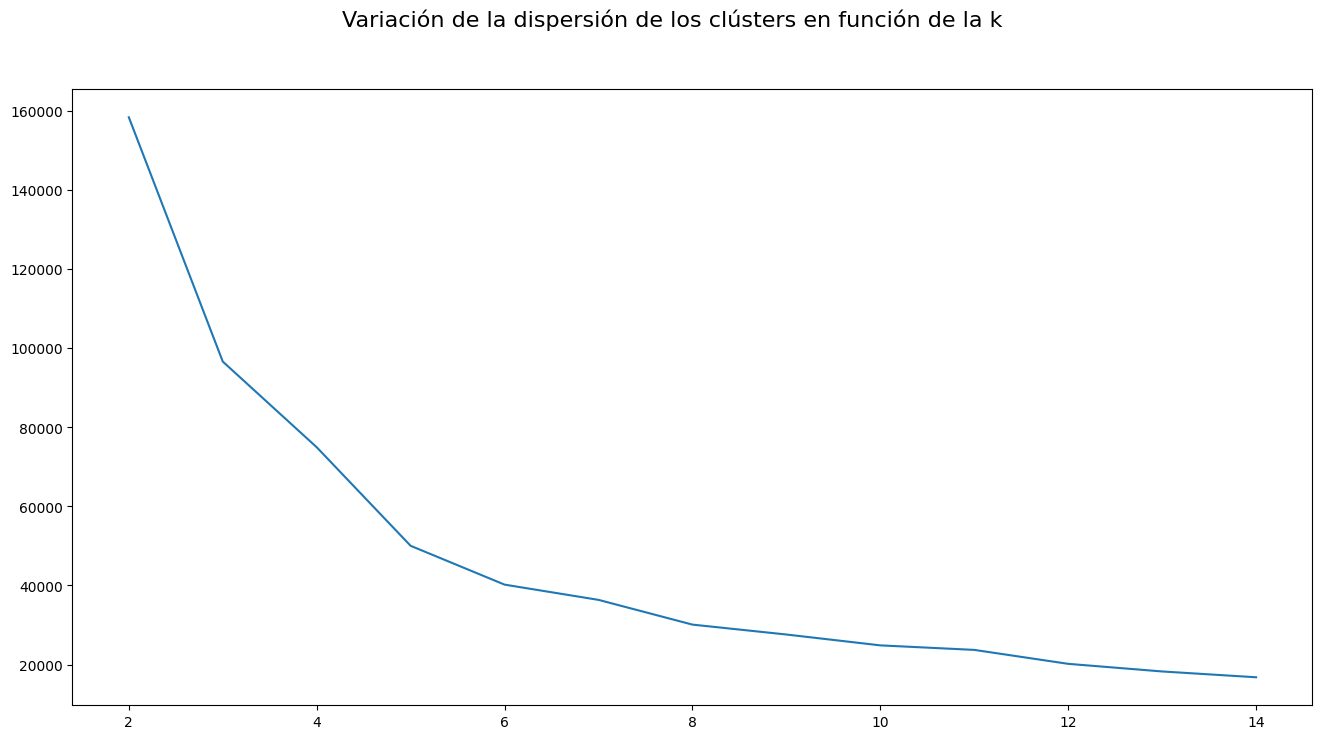

In [42]:
# Creamos una figura con un tamaño específico de 16x8 pulgadas
fig = plt.figure(figsize = (16, 8))

# Agregamos un subplot a la figura
ax = fig.add_subplot()

# Obtenemos los valores de las claves del diccionario 'sse' como una lista para el eje x
x_values = list(sse.keys())

# Obtenemos los valores del diccionario 'sse' como una lista para el eje y
y_values = list(sse.values())

# Graficamos los valores de x e y, etiquetando la línea como "Inertia/dispersión de los clústers"
ax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")

# Establecemos el título de la figura con un tamaño de fuente de 16
fig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize = 16)

# 6. Segmentación Clientes

In [43]:
# En el punto anterior definimos cuál es el número de clusters óptimo

# Definimos una pipeline con varios pasos:
pipe = Pipeline(steps = [
    ('Imputer', KNNImputer()),
    ('CustomTransformer', ClientIdFeatureGenerator),
    ('RobustScaler', RobustScaler(quantile_range = (0, 99.00))),
    
# Clustering utilizando KMeans con el número óptimo de clusters (6) y una semilla aleatoria para reproducibilidad.
    ('Clustering', KMeans(n_clusters=6, random_state = 175))
])

In [44]:
# Ajustamos la pipeline 'pipe' al DataFrame 'df_cluster'.
pipe.fit(df_cluster)

Pipeline(steps=[('Imputer', KNNImputer()),
                ('CustomTransformer',
                 FunctionTransformer(func=<function build_unique_id_features at 0x00000256A2518860>)),
                ('RobustScaler', RobustScaler(quantile_range=(0, 99.0))),
                ('Clustering', KMeans(n_clusters=6, random_state=175))])

In [45]:
# Transformamos el DataFrame 'df_cluster' utilizando los dos primeros pasos de la pipeline 'pipe'.

X_processed = pipe[:2].transform(df_cluster)

In [46]:
# Utilizamos el método predict de la pipeline 'pipe' para predecir los clusters de cada cliente en 'df_cluster'.
# La pipeline ya ha sido ajustada previamente con los datos de 'df_cluster'.
# El método predict aplica todos los pasos de la pipeline (imputación, transformación, escalado y clustering) para asignar un cluster a cada cliente.
labels = pipe.predict(df_cluster)

In [47]:
# Asignamos las etiquetas de los clusters a una nueva columna 'cluster' en el DataFrame 'X_processed'.
# Utilizamos las etiquetas generadas previamente por el modelo de clustering KMeans.
X_processed['cluster'] = labels

# 7. Ficha de los clientes

In [48]:
# Creamos un DataFrame vacío llamado 'ficha_df' que utilizaremos para almacenar los datos resumidos de cada cluster.
ficha_df = pd.DataFrame()

In [49]:
# Iteramos sobre cada columna en el DataFrame 'df_scaled_transformed'
for i, col in enumerate(df_scaled_transformed.columns):
    # Agrupamos los datos en 'X_processed' por la columna 'cluster' y calculamos estadísticas descriptivas para cada grupo
    # Luego, transponemos el resultado y seleccionamos todas las filas excepto la primera (que contiene el conteo)
    summary_data = X_processed[['cluster', col]].groupby('cluster').describe().T[1:]
    
    # Concatenamos los datos resumidos 'summary_data' al DataFrame 'ficha_df'
    ficha_df = pd.concat([ficha_df, summary_data])

In [50]:
# Aplicamos un gradiente de color al DataFrame 'ficha_df' para mejorar la visualización.
# Utilizamos el método 'style.background_gradient' para aplicar el gradiente.

ficha_df.style.background_gradient(cmap='Blues', axis=1)

In [51]:
# Definimos una lista 'out_index' que contiene las categorías principales de los indicadores.
# En este caso, tenemos dos categorías: 'Comportamiento financiero' y 'Fidelización y Antiguedad'.
out_index = ['Comportamiento financiero', 'Comportamiento financiero', 'Comportamiento financiero', 'Fidelización y Antiguedad','Fidelización y Antiguedad']

# Convertimos las columnas del DataFrame 'df_scaled_transformed' en una lista y la asignamos a 'inner_index'.
# Esta lista contiene los nombres de los indicadores específicos dentro de cada categoría principal.
inner_index = df_scaled_transformed.columns.tolist()

# Definimos una lista 'estadisticos' que contiene los nombres de las estadísticas descriptivas que queremos calcular.
# Estas estadísticas incluyen la media, desviación estándar, mínimo, mediana, percentil 25, percentil 75 y máximo.
estadisticos = ['Media', 'Desviación estándar', 'min', 'Mediana', '25%', '75%', 'max']


In [52]:
# Creamos una lista de tuplas 'new_multiindex' utilizando una comprensión de listas.
# Iteramos sobre cada combinación de 'oi' (categoría principal) y 'ii' (indicador específico) utilizando zip(out_index, inner_index).
# Para cada combinación de 'oi' e 'ii', iteramos sobre cada 'es' (estadístico) en la lista 'estadisticos'.
# La comprensión de listas genera una tupla (oi, ii, es) para cada combinación de 'oi', 'ii' y 'es'.
new_multiindex = [(oi, ii, es) for oi, ii in zip(out_index, inner_index) for es in estadisticos]

In [53]:
def generate_multiindex(list_of_tuples, names):
    # Creamos un MultiIndex a partir de una lista de tuplas.
    # Utilizamos el método 'from_tuples' de pandas para convertir la lista de tuplas en un MultiIndex.
    # Asignamos nombres a los niveles del MultiIndex utilizando el parámetro 'names'.
    return pd.MultiIndex.from_tuples(list_of_tuples, names = names)

In [54]:
# Definimos una lista llamada 'names' que contiene los nombres de los niveles del MultiIndex.
# Estos nombres se utilizarán para identificar y etiquetar los niveles del MultiIndex en el DataFrame 'ficha_df'.

names = ['Grupo Indicadores', 'Indicador', 'Estadístico']

In [55]:
# Generamos un MultiIndex a partir de la lista de tuplas 'new_multiindex'.
# Utilizamos la función 'generate_multiindex' que hemos definido previamente.
# Asignamos nombres a los niveles del MultiIndex utilizando la lista 'names'.
index_ficha = generate_multiindex(new_multiindex, names)

In [56]:
# Establecemos el índice del DataFrame 'ficha_df' utilizando el MultiIndex 'index_ficha'.
# Esto nos permite organizar y categorizar los datos en 'ficha_df' de manera jerárquica.
# El MultiIndex 'index_ficha' contiene tres niveles: 'Grupo Indicadores', 'Indicador' y 'Estadístico'.
# Cada nivel del MultiIndex nos ayuda a identificar y etiquetar los datos de manera más clara y estructurada.
ficha_df.set_index(index_ficha, inplace=True)

In [57]:
# Agrupamos el DataFrame 'X_processed' por la columna 'cluster' y contamos el número de ocurrencias en cada grupo.
# Esto nos da el tamaño de cada cluster.
# Utilizamos el método 'size()' para contar las ocurrencias y 'to_frame()' para convertir el resultado en un DataFrame.
# Luego, transponemos el DataFrame resultante utilizando 'T' para que los clusters sean las columnas y el tamaño de cada cluster sea una fila.
tamaño_cluster = X_processed.groupby('cluster').size().to_frame().T

In [58]:
# Establecemos el índice del DataFrame 'tamaño_cluster' utilizando un MultiIndex generado.
# Utilizamos la función 'generate_multiindex' que hemos definido previamente para crear el MultiIndex.
# El MultiIndex contiene una tupla con tres niveles: 'General', 'Clúster' y 'Tamaño'.
# Asignamos nombres a los niveles del MultiIndex utilizando la lista 'names'.
# Esto nos permite organizar y categorizar los datos en 'tamaño_cluster' de manera jerárquica.
tamaño_cluster.set_index(generate_multiindex([('General', 'Clúster', 'Tamaño')], names), inplace=True)

In [59]:
# Concatenamos el DataFrame 'tamaño_cluster' con el DataFrame 'ficha_df'.
# Esto nos permite agregar la información del tamaño de cada cluster al DataFrame 'ficha_df'.
# Utilizamos la función 'pd.concat' para realizar la concatenación.
# El resultado es un DataFrame que contiene tanto las estadísticas descriptivas de cada cluster como el tamaño de cada cluster.
ficha_df = pd.concat([tamaño_cluster, ficha_df])

In [60]:
ficha_df

cluster                                                                             0  \
Grupo Indicadores         Indicador                 Estadístico                         
General                   Clúster                   Tamaño               65780.000000   
Comportamiento financiero active_customer           Media                    1.000000   
                                                    Desviación estándar      0.000000   
                                                    min                      1.000000   
                                                    Mediana                  1.000000   
                                                    25%                      1.000000   
                                                    75%                      1.000000   
                                                    max                      1.000000   
                          total_productos_unicos    Media                    1.530693   
                                                    Desviación estándar      1.040003   
                                                    min                      0.000000   
                                                    Mediana                  1.000000   
                                                    25%                      1.000000   
                                                    75%                      2.000000   
                                                    max                      7.000000   
                          meses_desde_ultima_compra Media                    6.653924   
                                                    Desviación estándar      5.171216   
                                                    min                      0.000000   
                                                    Mediana                  2.966667   
                                                    25%                      6.033333   
                                                    75%                      9.100000   
                                                    max                     22.707346   
Fidelización y Antiguedad antiguedad                Media                  314.204469   
                                                    Desviación estándar    269.047757   
                                                    min                     -3.000000   
                                                    Mediana                177.000000   
                                                    25%                    253.000000   
                                                    75%                    310.000000   
                                                    max                   1607.000000   
                          fidelizacion              Media                    6.167376   
                                                    Desviación estándar      3.876327   
                                                    min                      0.000000   
                                                    Mediana                  3.000000   
                                                    25%                      7.000000   
                                                    75%                      9.000000   
                                                    max                     14.000000   

cluster                                                                              1  \
Grupo Indicadores         Indicador                 Estadístico                          
General                   Clúster                   Tamaño               107040.000000   
Comportamiento financiero active_customer           Media                     0.000000   
                                                    Desviación estándar       0.000000   
                                                    min                       0.000000   
                                                    Mediana                  

In [61]:
ficha_df.style.background_gradient(cmap='Blues', axis = 1)

In [62]:
# Restablecemos el índice del DataFrame 'X_processed' para convertir el índice actual en una columna.
# Esto nos permite trabajar con el índice como una columna normal y facilita la manipulación de los datos.
X_processed.reset_index(inplace=True)

In [63]:
# Seleccionamos las columnas 'pk_cid' y 'cluster' del DataFrame 'X_processed'
# Esto nos permite crear un nuevo DataFrame 'df_cluster_final' que contiene solo estas dos columnas
# 'pk_cid' identifica de manera única a cada cliente y 'cluster' indica el cluster asignado a cada cliente
df_cluster_final = X_processed[['pk_cid', 'cluster']]

In [64]:
df_cluster_final

,pk_cid,cluster
0,15891,2
1,16063,0
2,16203,0
3,16502,0
4,17457,5
...,...,...
454748,1553685,1
454749,1553686,1
454750,1553687,1
454751,1553688,1


In [65]:
# Guardamos el DataFrame 'df_cluster_final' en un archivo pickle.
# Utilizamos el método 'to_pickle' para serializar el DataFrame y almacenarlo en el archivo especificado.

df_cluster_final.to_pickle("pickle/df_clusters.pkl")

In [66]:
# Guardamos el DataFrame 'X_processed' en un archivo CSV.
# Utilizamos el método 'to_csv' para exportar el DataFrame a un archivo CSV.

X_processed.to_csv("reports/df_x_processed.csv")